# Bienvenue dans ce notebook qui vous présentera les différentes fonctions de notre projet de Data Mining !

## Evidemment, il est nécessaire de l'ouvrire depuis le dossier contenant tous les fichiers .csv et python puisque ils s'appellent les uns les autres à de nombreuses reprises . 


Cette première fonction permet de charger des images depuis un site internet regroupant plein d informations sur les pokemons. Celles-ci sont stockées dans le dossier "images". On peu retrer le nombre d'images à stocker en paramètre . 

**Fonctionnement :** on va parcourir avec Beautiful Soup la page HTML d'un "pokédex", un tableau regroupant différentes infos sur les pokémons. On va récupérer les **noms** des pokémons qu'on utilise en les rajoutant à une URL du même site qui ammène aux images qu'on peut alors télécharger.

In [7]:
from bs4 import BeautifulSoup
import os
import shutil #pip2 install shutil
from os.path  import basename
from urllib.request import Request, urlopen #pip3 install urllib3
from PIL import Image #pip3 install pillow

import requests;

#Va parcourir le code html du site renseigné pour extraire des noms de pokemon
def getURLImg():

    url='https://pokemondb.net/pokedex/stats/height-weight' 
    req = Request(url, headers={'User-Agent': 'XYZ/3.0'})
    codeHTML = urlopen(req, timeout=20).read()
    
    codeHTML=codeHTML.decode("utf-8")
    
    soup = BeautifulSoup(codeHTML,features="lxml") #On utlise Beautiful Soup pour notre web scraping
 
    names = soup.findAll('tr') #Les données sont cachées dans des tableaux html
    #print(images)
    
    listeimg=[] #La liste des noms des pokemons dont on va aller télécharger l'image
    for img in names:
        
        image = img.find_all('td')
        if len(image) == 0:
            continue
        image=image[1].getText().lower()
        if ' ' not in image and '♀' not in image and '♂' not in image and "'" not in image and "é" not in image: #On nettoie une premiere fois en filtrant les pokemons avec des noms comportant des caracteres spéciaux qui pourraient poser probleme plus tard
            #print(image)
            
            listeimg.append(image)
    #print(listeimg[0])       
   

    return listeimg

#fonction qui permet de créer un dossier(si il n'existe pas) et d'y stocker toutes les images
def saveImg(listeimg, nbreImages):

    shutil.rmtree('images') #permet de détruire automatiquement le fichier des images

    try:                    
            os.mkdir('images')
    except FileExistsError:
            print("fichier déjà créé")
    if len(listeimg)<nbreImages:
        nbreImages=len(listeimg)
    for i in range(0,nbreImages):     #on va charger sur le meme site de belles images qui correspondent aux pokemons dont on a chargé les noms
        f = open('images/'+listeimg[i]+'.jpg','wb')
        f.write(requests.get('https://img.pokemondb.net/artwork/large/'+listeimg[i]+'.jpg').content)
        im=Image.open('images/'+listeimg[i]+'.jpg')
        _, ext = os.path.splitext('images/'+listeimg[i]+'.jpg')  #On renomme correctement nos images
        #print(ext)
        f.close()

   
###########Main##############
def RecupImage(nbreImages):
    
    saveImg(getURLImg(), nbreImages)

    print("end")
if __name__ == "__main__":
    RecupImage(nbreImages=10)



end


Cette deuxième fonction parcourt de la même façon le tableau de pokémons, mais va cette fois-ci récupérer différentes données (taille, poids, type ...) de chacun de nos poémons dont nous avons téléchargé la photo, et stocker tout ça dans un fichier CSV (DataPokemon.csv).

In [8]:

from bs4 import BeautifulSoup
from os.path  import basename
from urllib.request import Request, urlopen
import csv


#On va de nouveau parcourir le tableau html à la recherche d'informations utilies sur nos pokemons
def getData(nbreImages):

    url='https://pokemondb.net/pokedex/stats/height-weight'
    req = Request(url, headers={'User-Agent': 'XYZ/3.0'})
    codeHTML = urlopen(req, timeout=50).read()
    
    codeHTML=codeHTML.decode("utf-8")
    
    
    soup = BeautifulSoup(codeHTML,features="lxml")
    
    
    results = soup.findAll('tr')
    rows = []
    rows.append(['Id','Name', 'Type1','Type2', 'height', 'poids']) #On va ordonner les informations qu'on poche dans un tableau 
    # boucle sur les résultats de la recherche
    i=0
    for result in results :
        if i < nbreImages:
            # On trouve toutes les colonnes
            data = result.find_all('td')
            # On va récuperer les infos qui nous intéressent dans chacune des colonnes
            if len(data) == 0:
                continue
            id = data[0].getText()
            name = data[1].getText().lower()
            strtype =data[2].getText()
            type =[]
            for mot in strtype.split(" "):
                if mot !="":
                    type.append(mot)
            if len(type)==1:
                type.append("None")
            height=data[4].getText()
            poids=data[6].getText()
            #print(height)
            if ' ' not in name and '♀' not in name and '♂' not in name and "'" not in name and "é" not in name: #De nouveau le filtrage pour les caracteres indésirables
                rows.append([id, name, type[0],type[1], height,poids])
                i+=1
            with open('DataPokemon.csv','w', newline='') as f_output:
                csv_output = csv.writer(f_output)   #On réécrit notre tableau dans un fichier csv, ligne par ligne
                csv_output.writerows(rows)
            

###########Main##############

def RecupData(nbreImages):
    getData(nbreImages)
    print("done")
if __name__ == "__main__":
    RecupData(nbreImages=10)



done


Cette fonction est un algorithme K-mean qui permet de déterminer les 2 couleurs dominantes de nos photos . On arrondit ensuite à la couleure à l'une des 27 couleurs "principale" la plus proche, ce qui facilitera les comparaisons des couleurs par la suite. On stocke le résultat dans un fichier CSV "DataCouleurTest.csv". Ce programme a un temps d'exécution assez long .  

*n-b :* On doit traiter de manière particulière le blanc , couleur de fond de toutes nos images. 

In [9]:
from os import listdir
from PIL import Image
import numpy

from sklearn.cluster import KMeans

import csv

def CouleurDominante():
    rows = [] #On crée la liste qu'on va remplire au fur et à mesure puis stocker dans un fichier csv
    rows.append(['Name', 'couleur1','couleur2'])
    for img in listdir("images"): #On va récuperer les images téléchargées
        pokemon = img.split(".")[0]
        imgfile = Image.open("images/"+img)  #Algo Kmeans largement inspiré de celui des tps
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
        clusters = KMeans(n_clusters = 5)
        clusters.fit(numarray)
        npbins = numpy.arange(0, 6)
        histogram = numpy.histogram(clusters.labels_, bins=npbins)
        
        hist=[]
        Index=[]
        for i in histogram[0]:   #On ne récupère que les 3 couleurs les plus dominantes en retriant 3 fois notre tableau
            hist.append(i); #Il faut d'abord transformer l'histogramme en tableau triable
        for i in range(0,3):
            Index.append(hist.index(max(hist))) #On récupere les indexes des 3 couleurs dominantes une par une 
            hist[hist.index(max(hist))]=0.0
        #print(Index)




    #Liste de toutes les couleurs principales avec leur code RGB hexa
        couleursMoyennes=[['black',[0,0,0]],['gray',[128,128,128]],['red',[255,0,0]],['maroon',[128,0,0]],['yellow',[255,255,0]],
        ['olive',[128,128,0]],['lime',[0,255,0]],['green',[0,128,0]],['aqua',[0,255,255]],
        ['teal',[0,128,128]],['blue',[0,0,255]],['navy',[0,0,128]],['fuchsia',[255,0,255]],['purple',[128,0,128]],['white',[255,255,255]],
        ['soft blue',[0,128,255]],['soft green',[0,255,128]],['soft purple',[128,0,255]],['purple-blue',[128,128,255]],['green-yellow',[128,255,0]],['very soft green',[128,255,128]],
        ['very soft blue',[128,255,255]],['pink',[255,0,128]],['orange',[255,128,0]],['beige',[255,128,128]],['soft pink',[255,128,255]],['soft orange',[255,255,128]]
        ]

        couleurs=[]
        for ind in Index: #On va maintenant arrondir les couleurs dominantes par la couleur principale la plus proche. 
            
            for i in range(0, len(couleursMoyennes)):
                if abs(round(clusters.cluster_centers_[ind][0])-couleursMoyennes[i][1][0])<64 and abs(round(clusters.cluster_centers_[ind][1])-couleursMoyennes[i][1][1])<64 and abs(round(clusters.cluster_centers_[ind][2])-couleursMoyennes[i][1][2])<64 :
                    #print(couleursMoyennes[i][0])
                    if couleursMoyennes[i][0] !='white':
                        couleurs.append(couleursMoyennes[i][0])
        while len(couleurs)!=2:
            couleurs.append('white')
                        
        rows.append([pokemon,couleurs[0],couleurs[1]]) #On ajoute ce résultat à un tableau csv. Comme nos images ont un fond blanc , on traite spécialement cette couleur.
        with open('DataCouleurTest.csv','w', newline='') as f_output:
                csv_output = csv.writer(f_output)
                csv_output.writerows(rows)


    print("end")
if __name__ == "__main__":    
    CouleurDominante()

end


Ce programme permet juste de relier dans un nouveau tableau csv (DataFinal.csv) les information qui nous intéressent provenant des tableaux csv  précédents (DataPokémon et DataCouleur). 

In [13]:
import pandas as pd

#On va dans ce code lier les datas de nos différents fichiers csv que nous avons rempli précédemment, pour réécrire un nouveau fichier tout beau tout neuf !


def JoinData():
    
    Data1 = pd.read_csv("./DataPokemon.csv", encoding = "ISO-8859-1") #on récupère les données sur les pokemons
    Data2= pd.read_csv("./DataCouleur.csv", encoding = "ISO-8859-1")
    Data1["Pokemon Name"]=Data1["Name"]
    Data1 =  Data1.set_index('Name')
    Data2 =  Data2.set_index('Name')
    Data3=pd.concat([Data1,Data2], axis=1,join='inner')#On fusionne nos différents tableaux avec comme PK les noms des pokemons
    Data4 = pd.DataFrame(Data3,  columns=['Pokemon Name','Type1', 'Type2','height','poids','couleur1','couleur2']) 

    Data4.to_csv('DataFinal.csv', index=False)   #On écrit tout ca dans un nouveau CSV


if __name__ == "__main__":    
    JoinData()



Ce programme permet d afficher dans une fenetre tkinter toutes les données du fichier DataFinal, et nous avons implémenté des fonctionnalités supplémentaire pour le filtrage et/ou le tri .

In [14]:
import pandas as pd

from pandastable import Table

from tkinter import *

#On va afficher dans un tableau les données récoltées. On va pouvoir trier et filtrer ce tableau 
class Window(Frame):
    def __init__(self, master=None):
        Frame.__init__(self, master)
        self.master = master

        self.Data4 = pd.read_csv("DataFinal.csv", encoding = "ISO-8859-1")

        self.Data5 = pd.read_csv("DataFinal.csv", encoding = "ISO-8859-1")

        self.frame = Frame(self.master)
        self.frame.pack(fill='both', expand=TRUE)
        
        Tableau = Table(self.frame, dataframe=self.Data4)
        Tableau.show()

        Types=["None","Normal", "Fire","Water","Grass","Electric","Ice","Fighting","Poison","Ground","Flying","Psychic","Bug","Rock","Ghost","Dark","Dragon","Steel","Fairy"]
        Couleurs=['black','gray','red','maroon','yellow','olive','lime','green','aqua','teal','blue','navy','fuchsia','purple','white','soft blue','soft green','soft purple','purple-blue','green-yellow','very soft green','very soft blue','pink','orange','beige','soft pink','soft orange']

        
        menu = Menu(self.master) #Création des menus d'option pour le tri et le filtrage
        self.master.config(menu=menu)

        filtrage = Menu(menu)
        filtrage.add_command(label="No Filter", command=lambda:self.Reset())

        filtrageType1 =Menu(filtrage)
        filtrageType2 =Menu(filtrage)

        filtrageCouleur1 =Menu(filtrage)
        filtrageCouleur2 =Menu(filtrage)

        for param in Types:
           
            filtrageType1.add_command(label=param, command=lambda param=param:self.Filtre(param, "Type1"))
            
            filtrageType2.add_command(label=param, command=lambda param=param:self.Filtre(param, "Type2"))

        
        
        for param in Couleurs:
               
            filtrageCouleur1.add_command(label=param, command=lambda param=param:self.Filtre(param, "couleur1"))
            
            filtrageCouleur2.add_command(label=param, command=lambda param=param:self.Filtre(param, "couleur2"))
        
        filtrage.add_cascade(label="Type1", menu=filtrageType1)
        filtrage.add_cascade(label="Type2", menu=filtrageType2)
        filtrage.add_cascade(label="Couleur1", menu=filtrageCouleur1)
        filtrage.add_cascade(label="Couleur2", menu=filtrageCouleur2)
        
        

        tri = Menu(menu)
        
        triPoids =Menu(tri)
        triPoids.add_command(label="⇧", command=lambda:self.Tri("height", True))
        triPoids.add_command(label="⇩", command=lambda:self.Tri("height", False))
        
        triTaille =Menu(filtrage)
        triTaille.add_command(label="⇧", command=lambda:self.Tri("poids", True))
        triTaille.add_command(label="⇩", command=lambda:self.Tri("poids", False))

        triNom =Menu(filtrage)
        triNom.add_command(label="⇧", command=lambda:self.Tri("Pokemon Name", True))
        triNom.add_command(label="⇩", command=lambda:self.Tri("Pokemon Name", False))

        tri.add_cascade(label="Taille", menu=triPoids)
        tri.add_cascade(label="Poids", menu=triTaille)
        tri.add_cascade(label="Nom", menu=triNom)

        menu.add_cascade(label="Filtrage par", menu=filtrage)
        menu.add_cascade(label="Tri par", menu=tri)

        

    def Filtre( self, param, titre): #Filtrage de la data en fonction des parametres
        
        self.Data5 = self.Data4[(self.Data4[titre].isin([param])) ]
            
        self.frame.destroy()
        
        self.frame = Frame(self.master) #On détruit puis recontruit le tableau avec les nouvelles données
        self.frame.pack(fill='both', expand=TRUE)
        Tableau = Table(self.frame, dataframe=self.Data5)
        Tableau.show()
    
    def Reset(self):#Permet de revenir au tabeau d'origine.

        self.Data5=self.Data4
        self.frame.destroy()
        
        self.frame = Frame(self.master)
        self.frame.pack(fill='both', expand=TRUE)
        Tableau = Table(self.frame, dataframe=self.Data5)
        Tableau.show()
    
    def Tri(self, param, bool): #On tri le tableau courant en fonction des parametres d'entrée
        self.Data5=self.Data5.sort_values(by=param, ascending=bool)
        self.frame.destroy()
        
        self.frame = Frame(self.master)
        self.frame.pack(fill='both', expand=TRUE)
        Tableau = Table(self.frame, dataframe=self.Data5)
        Tableau.show()
   
        
def AffichageDonnees(): #Création de la fenetre tkinter

    fenetre = Tk()
    fenetre.title('Affichage des données')
    fenetre.geometry('900x800')
    Window(fenetre)

    fenetre.mainloop()

if __name__ == "__main__":
    AffichageDonnees()






Ce programme permet d afficher différentes statistiques sur les données sous formes de diagrammes

In [15]:
import pandas as pd

import matplotlib.pyplot as plot



from tkinter import *



#affichage de différents diagrammes représentant les statistiques de nos données
class Window(Frame):
    def __init__(self, master=None):
        Frame.__init__(self, master)
        self.master = master

        
        self.Data4 = pd.read_csv("DataFinal.csv", encoding = "ISO-8859-1")
        

        self.modeAffichage = 'bar' #Des checkboxes permettent de sélectionner si on veut trier ou non nos histogrammes, et afficher ou non le mode cammembert
        self.tri = False

        """ self.var2 = IntVar()
        checkPie = Checkbutton(self.master, text='Mode camembert',variable=self.var2, onvalue=1, offvalue=0, command=lambda:self.ChangeMode())
        checkPie.pack(padx=3, pady=3)

        self.var = IntVar()
        checkTri = Checkbutton(self.master, text='Données triées',variable=self.var, onvalue=1, offvalue=0, command=lambda:self.ChangeTri())
        checkTri.pack(padx=2, pady=2) """ #non fonctionnel sur jupyter lab qui ouvre une fenetre dans l'éditeur et semble donc ne pas prendre en compte le tri et le changement vers le mode pie. 

        StatType1 = Button(self.master, fg ='blue' ,width=30, height=2, text="Nombre de pokemons par Type1", command=lambda:self.PrintHist("Type1"))
        StatType1.pack(padx=10, pady=10)

        StatType2 = Button(self.master,fg ='purple' ,width=30, height=2, text="Nombre de pokemons par Type2", command=lambda:self.PrintHist("Type2"))
        StatType2.pack(padx=10, pady=10)

        StatCouleur1 = Button(self.master, fg ='blue' ,width=30, height=2,text="Nombre de pokemons par Couleur1", command=lambda:self.PrintHist("couleur1"))
        StatCouleur1.pack(padx=10, pady=10)

        StatCouleur2 = Button(self.master,fg ='purple' ,width=30, height=2, text="Nombre de pokemons par Couleur2", command=lambda:self.PrintHist("couleur2"))
        StatCouleur2.pack(padx=10, pady=10)

        StatGroupPoids = Button(self.master,fg ='blue' ,width=30, height=2, text="Poids moyen des pokemons par type", command=lambda:self.PrintHistGrouped("poids","(en kg)"))
        StatGroupPoids.pack(padx=10, pady=10)

        StatGroupTaille = Button(self.master,fg ='purple' ,width=30, height=2, text="Taille moyenne des pokemons par type", command=lambda:self.PrintHistGrouped("height","(en m)"))
        StatGroupTaille.pack(padx=10, pady=10)

        # StatHeigh = Button(self.master, text="Nombre de pokemons par taille ", command=lambda:self.PrintHist("taille (en m)"))
        # StatHeigh.pack(padx=10, pady=10)


    def PrintHist(self, param):#On affiche le graphe adéquat en appliquant value_counts a la colonne souhaitée avant de plot
        
        plot.clf()
        self.graph= self.Data4[param].value_counts(normalize=False, sort=self.tri).plot(kind=self.modeAffichage, title="Nombre de pokemons par "+param)
        
        plot.show()

    def PrintHistGrouped(self, param, unité):
        
        plot.close() #probleme avec clr pour cette fct
        self.Data5=self.Data4[["Type1",param]].groupby("Type1").mean()
        
        self.Data5.plot(kind='bar', title= param+" moyen "+unité+" des pokemons par type")#pas pertinent de mettre un affichage "pie" pour ces stats
        
        plot.show()

    def ChangeMode(self):
        if (self.var2.get()==1):
            self.modeAffichage='pie'
        else:
            self.modeAffichage='bar'

    def ChangeTri(self):
        if (self.var.get()==1):
            self.tri=True
        else:
            self.tri=False
        
        
def Statistiques(): #Création de la fenetre tkinter

    fenetre = Tk()
    fenetre.title('Affichage des données statistiques')
    fenetre.geometry('300x450')
    Window(fenetre)

    fenetre.mainloop()

if __name__ == "__main__":
    Statistiques()


Ce programme gère la connexion d un utilisateur . On va regarder si le pseudo et le mot de passe renseignés correspondent bien a l une des lignes de **user.csv**, notre bDD utilisateurs . Un nouvel utilisateur peut également décider de s'inscrire . Il ne peut alors pas choisir un pseudo déjà utilisé. 

In [16]:
#!/usr/bin/ev python
#coding: utf-8

from tkinter import  * #Mauvaise pratique qu'on retrouvera tout au long du projet mais plus le temps d'importer "as tk"....
import pandas as pd
import Inscriptions
import csv

class Window(Frame):
    def __init__(self, master=None):

        Frame.__init__(self, master)

        self.master = master

        self.isInUsers = False

        self.ListUsers = pd.read_csv("Users.csv", encoding = "ISO-8859-1")# lecture liste utlisateur

        #Zone de texte pour le pseudo 
        etiquettePseudo = Label(self.master, text='Pseudo :')
        etiquettePseudo.grid(row=0, column=0,pady = 10)
        self.entreePseudo = Entry(self.master, width=30)
        self.entreePseudo.grid(row=0, column=1,padx=10, pady = 10)
        
        # zone pour le Mot de passe
        etiquetteMdp = Label(self.master, text='Mot de passe :')
        etiquetteMdp.grid(row=1, column=0, pady = 10)
        self.entreeMdp = Entry(self.master, width=30, show="*")
        self.entreeMdp.grid(row=1, column=1,padx=10, pady = 10)

        #Bouton se connecter
        BoutonCo=Button(self.master, fg ='green' ,width=12, height=2, text="Se connecter", command=lambda:self.VerifCo())
        BoutonCo.grid(row=2, column=0,padx=10, pady = 10)

        #Bouton s'inscrire
        BoutonNewco=Button(self.master, fg ='blue' ,width=12, height=2, text="S'inscrire", command=lambda:self.GoInscription())
        BoutonNewco.grid(row=2, column=1, padx=10, pady = 10,sticky='w')

    def VerifCo(self):
        """ si l'utilisateur selectionne se connecter
        """

        user =[self.entreePseudo.get(), self.entreeMdp.get()]
        
        with open('Users.csv','r') as users:# ouverture utilisateur en mode lecture

            reader=csv.reader(users)
            header = next(users) #On ne veut pas iterer sur la premiere ligne qui correspond au nom des clonens, on le skip donc

            for line in reader:

                if (line[0:2]==user):

                    UserCourant=[]
                    UserCourant.append(['Pseudo'])
                    UserCourant.append([self.entreePseudo.get()])

                    with open('UserCourant.csv','w', newline='') as f_output:

                        csv_output = csv.writer(f_output)   
                        csv_output.writerows(UserCourant)
                        
                    self.isInUsers=True
                    self.master.destroy()

                    break

            if (self.isInUsers==False):

                MessageErreur= Label(self.master, text='Identification ratee', fg ='red')
                MessageErreur.grid(row=3, column=1, pady = 10)
            
        
    
    def GoInscription(self):
        """ si l'utilisateur utilise inscription
        """
        
        self.master.destroy()
        self.isInUsers=Inscriptions.Inscription()



def Connexion(): #Creation de la fenetre tkinter

    fenetre = Tk()
    fenetre.title('Interface Connexion')
    fenetre.geometry()
    Win = Window(fenetre)

    fenetre.mainloop()
    return Win.isInUsers


if __name__ == "__main__":
    Connexion()

Ce script est celui qui est voué à etre lancé par l utilisateur, puisque il regroupe tous les scripts vus précédemment en les appelant au fur et à mesure.

In [17]:

# This Python file uses the following encoding: utf-8

from tkinter import *
import pandas as pd
from PIL import Image, ImageTk 

import Connexion
import RecupImage
import RecupData
import couleurDominante
import AffichageDonnees
import AffichDonneesPerso
import Statistiques
import JoinData

import ImagePropose


class Fenetre(Toplevel):
    def __init__(self,master=None):

        Toplevel.__init__(self,master)
        self.title("Like/dislike")
        self.geometry("1080x720")
        self.i=1
        self.Data = pd.read_csv("./DataFinal.csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
        self.pokemon_name = self.Data['Pokemon Name'][:16] 

        #tableau de like and dislike remplie par l'utilisateur
        self.choix_de_utilisateur = []
        self.choix_de_utilisateur.append('dislike')
        
        self.image = Image.open('./images/'+self.pokemon_name[self.i]+'.jpg')

        self.image2 =self.image.resize((int(self.image.width/1.5),int(self.image.height/1.5)))
        # Remplace PhotoImage de Tkinter par celui de PIL
        self.photo = ImageTk.PhotoImage( self.image2)

        self.canvas = Canvas(self, width=self.photo.width(), height=self.photo.height())
        
        self.canvas.pack(side=TOP, fill='both', expand = True)
        #self.canvas.create_text(500, 360, text="Boom !", fill="red")
        self.canvas.create_image(500, 360,anchor='center',image=self.photo)

        #bouton de Like
        BoutonLike=Button(self, fg ='green' ,width=12, height=2, text="Like", command=lambda:self.LikeOrDislike("like"))
        BoutonLike.pack(side=RIGHT, fill='both', padx=50, pady=20)

        #bouton de dislike
        BoutonDislike=Button(self, fg ='red' ,width=12, height=2, text="Dislike", command=lambda:self.LikeOrDislike("dislike"))
        BoutonDislike.pack(side=LEFT, fill='both', padx=50, pady=20)


    def LikeOrDislike(self, appreciation):
        """ met un dislike au pokémon et passe à l'image suivante s'il y en a une
        """
        if appreciation=="like":
            self.choix_de_utilisateur.append('like')
        else:
            self.choix_de_utilisateur.append('dislike')
            

        if (self.i < 14 ):
            
            # permet de selectionner le bon nom dans le dans le csv
            
            self.i+=1
            self.image = Image.open('./images/'+self.pokemon_name[self.i]+'.jpg')
            self.image2 =self.image.resize((int(self.image.width/1.5),int(self.image.height/1.5)))
            # Remplace PhotoImage de Tkinter par celui de PIL
            self.photo = ImageTk.PhotoImage(self.image2)

            
            self.canvas.create_image(540,360,anchor='center',image=self.photo)
            self.canvas.pack(side=TOP, fill='both', expand = True)
            self.Write()
        else:
            #une fois terminé le fenêtre se détruit en l'utilisateur est renvoyé sur la fenêtre de selection des images 
            self.destroy()
    
    def Write(self):
        utilisateur = pd.read_csv("./UserCourant.csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
        utilisateur = utilisateur.values.tolist()
        utilisateur = utilisateur[0][0] # utilisateur actuelle
        dataframe_un = pd.DataFrame(self.choix_de_utilisateur,columns=['like_and_dislike'])# création dataframe contenant les likes et dislikes de l'utilisateur
        dataframe_deux = pd.concat([dataframe_un , self.Data[:14]], axis = 1)# permet de concaténer des données
        dataframe_deux.to_csv('Data_like_dislike_'+utilisateur+'.csv', index=False)   #On écrit tout ca dans un nouveau CSV propre à chaque utilisateur 

class Window(Frame):
    def __init__(self, master=None):

        Frame.__init__(self, master)
        self.master = master

        #demande combien d'image doit être chargé
        etiquetteNbreImages = Label(self.master, text='Combien d\'images voulez vous charger ? (minimum 20) :')
        etiquetteNbreImages.grid(row=0, column=0, padx=5,pady = 5)
        self.entreeNbreImages = Entry(self.master, width=10)
        self.entreeNbreImages.grid(row=0, column=1,padx=5, pady = 5)
        
        #bouton de validation
        self.BoutonValider=Button(self.master, fg ='green' ,width=12, height=2, text="Valider", command=lambda:self.ValidDL())
        self.BoutonValider.grid(row=1, column=0, padx=10,pady = 10)

    
    def ValidDL(self):

        NbreImages=eval(self.entreeNbreImages.get())#récupère le nombre d'image demandé

        RecupImage.RecupImage(NbreImages) 
        RecupData.RecupData(NbreImages) #On recupere d'autres informations en parcourant la page web
  
        #CouleurDominante.CouleurDominante() 

        JoinData.JoinData()# crée un tableau contenant les images que l'utilisateur va tester
        
        self.BoutonValider.destroy()

        etiquetteNbreImages = Label(self.master,fg='green', text='Telechargement termine !!!')
        etiquetteNbreImages.grid(row=1, column=1, padx=5,pady = 5, sticky='w')
        

        BoutonAffichage=Button(self.master, fg ='blue' , height=2, text="Afficher les donnees", command=lambda:AffichageDonnees.AffichageDonnees())
        BoutonAffichage.grid(row=3, column=0, padx=10,pady = 15)

        BoutonStats=Button(self.master, fg ='purple' , height=2, text="Afficher les stats", command=lambda:Statistiques.Statistiques())
        BoutonStats.grid(row=3, column=1, padx=10,pady = 15, sticky='w')

        BoutonAffichagePerso=Button(self.master, fg ='orange' , height=2, text="Afficher les donnees perso", command=lambda:AffichDonneesPerso.AffichDonneesPerso())
        BoutonAffichagePerso.grid(row=2, column=1, padx=10,pady = 15)


        BoutonTestPref=Button(self.master, fg ='orange' , height=2, text="Faire le test de preferences", command=lambda:self.Testpref())
        BoutonTestPref.grid(row=2, column=0, padx=10,pady = 15)

        
    
    def Testpref(self):
        """lance la phase de like and dislike
        """
        fen1= Fenetre()
        #TestPref.TestPref()
        self.BoutonPropositons=Button(self.master, fg ='purple' , height=2, text="images proposées", command=lambda:self.Imagepropose())
        self.BoutonPropositons.grid(row=1, column=0, padx=10,pady = 15)
        
    def Imagepropose(self):
        """Propose des images par l'algorithme de rapporchement préférentiels
        """
        
        ImagePropose.ImagePropose()



def PagePrincipale(): 
    """Creation de la fenetre tkinter
    """

    fenetre = Tk()
    fenetre.title('Page Principale')
    Window(fenetre)
    fenetre.mainloop()

if __name__ == "__main__":

    InscriptionReussie = Connexion.Connexion()#appelle fonction Connexion

    if (InscriptionReussie):
        PagePrincipale()


-Ce script trie si il est appelé via un autre script permet de séparer les likes des dislikes de l'utilisateur et de générer un csv contenant les suggestions pour l'utilisateur via la fonction Analyse_de_donnees

-Si il est appelé en tant que main ce script génère un tableau de like_utilisateur selon la fonction utilisateur choisi (il y a 3 fonctions utilisateur différentes ) et sort un tableau contenant les suggestions pour ces utilisateurs ( le lancer en tant que main permet de tester l'algorithme de selection d'image pour l'utilisateur)

In [18]:
#Demandez à l'utilisateur de sélectionner quelques images et d'ajouter des balises. Pour chaque utilisateur, 
#vous êtes maintenant prêt à construire un profil de préférences d'utilisateur,
#basé sur cette sélection. Vous pouvez recueillir les informations suivantes manuellement,
#mais l'objectif de cette tâche consiste à les obtenir en utilisant les images sélectionnées de manière automatisée :

#    Couleurs préférées
#    Orientation de l'image préférée
#    Tailles d'images préférées (vignettes, grandes images, images de taille moyenne images, etc.)
#    Balises favorites
#    ...

#support

import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plot






# l'utilisateur 1 like et dislike aléatoirement, la fonction retourne la liste d'element liké

def Utilisateur1():
        choix_de_utilisateur = []

        for i in pokemon_name:
                
                choix = random.choice([True,False])

                if(choix == True):
                        choix_de_utilisateur.append('like')
                else:
                        choix_de_utilisateur.append('dislike') 

        dataframe_un = pd.DataFrame(choix_de_utilisateur,columns=['like_and_dislike'])
        dataframe_trois = pd.concat([dataframe_un , Data[0:50]], axis = 1)# permet de concaténer des données
        dataframe_quatre = dataframe_trois.set_index('like_and_dislike')# met la colonne dislike and like index
        dataframe_like = dataframe_quatre.drop(['dislike'])#enlève ce qui possède une colonne dislike

        return dataframe_like


#l'utilisateur 2 like uniquement les types 'Bug'

def Utilisateur2():

        choix_de_utilisateur = [] #stock  les likes et dislikes de l'utilisateur

        aime = 'Bug' # il aime les types bug

        for i in pokemon_type: #like si c'est un 'bug'
                
                if (i == aime):
                        choix_de_utilisateur.append('like')
                else:
                        choix_de_utilisateur.append('dislike')


        dataframe = pd.DataFrame(choix_de_utilisateur,columns=['like_and_dislike'])# création d'une dataframe avec les likes et dislikes de l'utilisateur
        dataframe = pd.concat([dataframe , Data[0:50]], axis = 1)# permet de concaténer des données
        dataframe = dataframe.set_index('like_and_dislike')# met la colonne dislike and like index
        dataframe_like = dataframe.drop(['dislike'])#enlèe ce qui possède une colonne dislike

        return dataframe_like

#l'utilisateur 3 like uniquement les 'grands' pokémon

def Utilisateur3():

        choix_de_utilisateur = [] #stock  les likes et dislikes de l'utilisateur

        taille_aime = 1.5

        for i in pokemon_height: #like si c'est un 'bug'
                
                if (i > taille_aime):
                        choix_de_utilisateur.append('like')
                else:
                        choix_de_utilisateur.append('dislike')


        dataframe = pd.DataFrame(choix_de_utilisateur,columns=['like_and_dislike'])# création d'une dataframe avec les likes et dislikes de l'utilisateur
        dataframe = pd.concat([dataframe , Data[0:50]], axis = 1)# permet de concaténer des données
        dataframe = dataframe.set_index('like_and_dislike')# met la colonne dislike and like index
        dataframe_like = dataframe.drop(['dislike'])#enlèe ce qui possède une colonne dislike

        return dataframe_like

def recommandation(tableau_de_like):

        Aime = [] # contient ce que l'utilisateur aime et peu aimer
        Proposition = [] # contient uniquement les images recommandées

        # cherche des pokémons dans la grande liste ayant des caractéristiques similaires a cceux liké (taille, poids similaire, type identique)
        for i in tableau_de_like:
                for j in tableau_des_pokemon:
                        if ((i[1] == j[1]) and ((j[3]-1)<i[3]< (j[3]+1)) and ((j[4]-30)<i[4]< (j[4]+30))):
                        # if (type == type and  <height< and <poids<) 
                                Aime.append(j)

        for i in range(len(Aime) ): 
                if (Aime[i][0] not in Proposition):# pour éviter les redondance on met une fois chaque pokémon jugé aimé 
                        Proposition.append(Aime[i][0])
        

        for i in Proposition:# affichage
                print(i)

        return Proposition

def Analyse_de_donnees():
        """fonction utilisé par ImagePropose.py afin de crée sa liste de pokémon à proposer
        """
        #récupère l'utilisateur actuel
        utilisateur = pd.read_csv("./UserCourant.csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
        utilisateur = utilisateur.values.tolist()
        utilisateur = utilisateur[0][0] # utilisateur actuelle

        Data = pd.read_csv("./Data_like_dislike_"+utilisateur+".csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
        Data = Data.set_index('like_and_dislike')# met la colonne dislike and like index
        Data = Data.drop(['dislike'])#enlèe ce qui possède une colonne dislike
        Data = Data.values.tolist()# transforme le tableau pandas en list
        
        tableau_des_pokemon = pd.read_csv("./DataTotal.csv", encoding = "ISO-8859-1")
        tableau_des_pokemon = tableau_des_pokemon.values.tolist()
        
        Aime = [] # contient ce que l'utilisateur aime et peu aimer
        Proposition = [] # contient uniquement les images recommandées

        # cherche des pokémons dans la grande liste ayant des caractéristiques similaires a cceux liké (taille, poids similaire, type identique)
        for i in Data:
                for j in tableau_des_pokemon:
                        if ((i[1] == j[1])and ((j[3]-1)<i[3]< (j[3]+1)) and ((j[4]-30)<i[4]< (j[4]+30))):
                        # if (type == type and  <height< and <poids< and couleur == couleur) 
                                
                                Aime.append(j)
                                
        for i in range(len(Aime) ): 
                if (Aime[i][0] not in Proposition):# pour éviter les redondance on met une fois chaque pokémon jugé aimé 
                        Proposition.append(Aime[i][0])
        

   
        dataframe_proposition = pd.DataFrame(Proposition,columns=['pokemon_selection'])# création dataframe contenant les propositions pour l'utilisateur
        dataframe_proposition.to_csv('Data_recommander_pour_utilisateur.csv', index=False)   #On écrit tout ca dans un nouveau CSV
        

###Main###
# fonction si l'on a à disposition le csv DataTotal.csv
if __name__ == "__main__":

        Data = pd.read_csv("./DataTotal.csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons

        pokemon_name = Data['Pokemon Name'][0:50] # on prend les 50 premières ligne de la colonne Name 
        pokemon_type = Data['Type1'][0:50] #on prend les 50 premieres ligne de la colonne type
        pokemon_height = Data['height'][0:50]

        dataframe_like = Utilisateur1() # on choisie quelle utilisateur remplira notre tableau de like and dislike
        print(dataframe_like)

        tableau_de_like_U1 = dataframe_like.values.tolist()# transforme le tableau pandas en list 
        tableau_des_pokemon = Data.values.tolist() 


        recommandation(tableau_de_like_U1) 



                 Pokemon Name   Type1   Type2  height  poids     couleur1  \
like_and_dislike                                                            
like               charmeleon    Fire    None     1.1   19.0        beige   
like                charizard    Fire  Flying     1.7   90.5        beige   
like                 squirtle   Water    None     0.5    9.0         gray   
like                 caterpie     Bug    None     0.3    2.9         gray   
like                  metapod     Bug    None     0.7    9.9         gray   
like               butterfree     Bug  Flying     1.1   32.0         gray   
like                   weedle     Bug  Poison     0.3    3.2         gray   
like                   kakuna     Bug  Poison     0.6   10.0        beige   
like                 beedrill     Bug  Poison     1.0   29.5        beige   
like                pidgeotto  Normal  Flying     1.1   30.0        beige   
like                  pidgeot  Normal  Flying     1.5   39.5  soft orange   

Ce script génère une fenêtre qui affiche a l'utilisateur des images susceptible de lui plaire un fois terminer ou la fenêtre générer fermer, le script renvoie l'utilisateur sur la page "afficher image"

In [19]:
# This Python file uses the following encoding: utf-8

import pandas as pd
from tkinter import *
import tkinter as tk
import PagePrincipale
import Analyse_de_donnees
from PIL import Image, ImageTk 
from bs4 import BeautifulSoup
import os
import shutil #pip2 install shutil
from os.path  import basename
from urllib.request import Request, urlopen #pip3 install urllib3
from PIL import Image #pip3 install pillow

import requests;

def ImagePropose():

    class window(Frame):
        def __init__(self, master=None):

            Frame.__init__(self, master)

            self.master = master
            
            #bouton suivant
            Boutonsuivant=Button(self.master, fg ='green' ,width=12, height=2, text="Suivant", command=lambda:self.suivant())
            Boutonsuivant.pack(side=BOTTOM, fill='both')




        def suivant(self):
            """ passe au pokémon qui devrait plaire suivant
            """
            global i
            if (i < len(pokemon_name) ):

                self.master.destroy()
                #création première fenêtre
                fenetre = tk.Tk()

                #paramètre de la fenêtre 
                fenetre.title("pokémon")
                fenetre.geometry("1080x720")
                   
                # on télécharges l'image que l'on veut montrer
                f = open('images/'+pokemon_name[i]+'.jpg','wb')
                f.write(requests.get('https://img.pokemondb.net/artwork/large/'+pokemon_name[i]+'.jpg').content)
                im=Image.open('images/'+pokemon_name[i]+'.jpg')
                _, ext = os.path.splitext('images/'+pokemon_name[i]+'.jpg')  #On renomme correctement nos images
                f.close()
                
                name = pokemon_name[i]
                i+=1
                image = Image.open('./images/'+name+'.jpg')
                image2 =image.resize((int(image.width/1.5),int(image.height/1.5)))

                # Remplace PhotoImage de Tkinter par celui de PIL
                photo = ImageTk.PhotoImage(image2)

                canvas = tk.Canvas(fenetre, width=photo.width(), height=photo.height())
                canvas.create_image(540,360,anchor='center',image=photo)
                canvas.pack(side=TOP, fill='both', expand = True)

                window(fenetre)

                # affichage
                fenetre.mainloop()
            else:
                self.master.destroy()

    Analyse_de_donnees.Analyse_de_donnees()#genere le fichier csv contenant les recommendation pour l'utilisateur courant 

    pokemon_name = pd.read_csv("./Data_recommander_pour_utilisateur.csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
    pokemon_name = pokemon_name['pokemon_selection']
    print(pokemon_name)


    #variable utiliser pour balayer les différentes images
    global i 
    i = 0
    #création première fenêtre
    fenetre = tk.Tk()

    #paramètre de la fenêtre 
    fenetre.title("Pokémon")
    fenetre.geometry("1080x720")

    # on crée le dossier de stockage des images
    try:                    
            os.mkdir('images')
    except FileExistsError:
            print("fichier déjà créé")
    
    # on télécharges l'image que l'on veut montrer
    f = open('images/'+pokemon_name[i]+'.jpg','wb')
    f.write(requests.get('https://img.pokemondb.net/artwork/large/'+pokemon_name[i]+'.jpg').content)
    im=Image.open('images/'+pokemon_name[i]+'.jpg')
    _, ext = os.path.splitext('images/'+pokemon_name[i]+'.jpg')  #On renomme correctement nos images
    f.close()
    
    image = Image.open('./images/'+pokemon_name[i]+'.jpg')

    i+=1

    image2 =image.resize((int(image.width/1.5),int(image.height/1.5)))
    # Remplace PhotoImage de Tkinter par celui de PIL
    photo = ImageTk.PhotoImage(image2)

    #label = tk.Label(fenetre, image=photo)
    #label.pack()
    canvas = tk.Canvas(fenetre, width=photo.width(), height=photo.height())
    canvas.create_image(540,360,anchor='center',image=photo)
    canvas.pack(side=TOP, fill='both', expand = True)

    window(fenetre)

    # affichage
    fenetre.mainloop()

    PagePrincipale.PagePrincipale()

# Permet de tester ImagePropose seul
# Attention, le programme à besoin de certain csv pour fonctionner 
if __name__ == "__main__":
    ImagePropose()


0      charmander
1      charmeleon
2          vulpix
3       ninetales
4       growlithe
          ...    
192       ariados
193         yanma
194     vespiquen
195    escavalier
196        durant
Name: pokemon_selection, Length: 197, dtype: object
fichier déjà créé


Ce code permet d'afficher des stats sur les données des pokémons likés

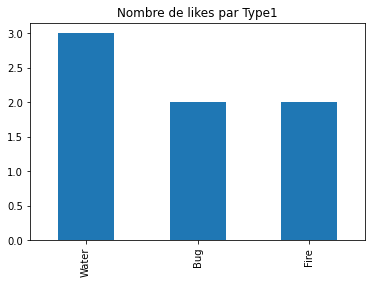

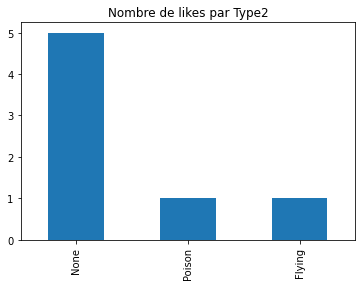

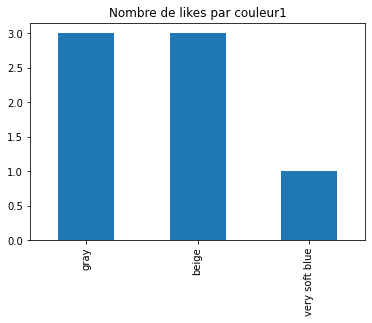

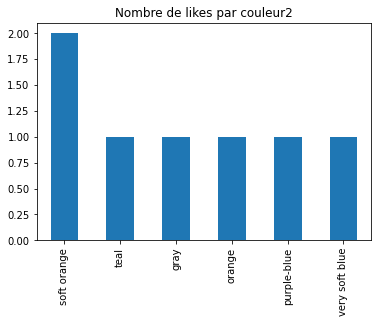

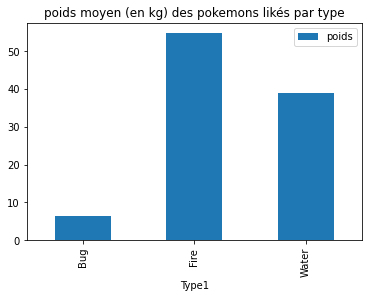

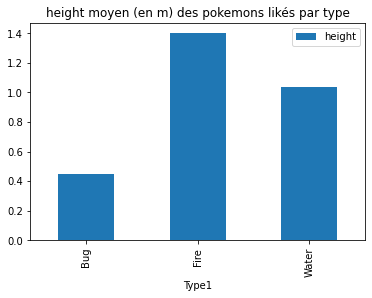

In [20]:
import pandas as pd

import matplotlib.pyplot as plot



from tkinter import *



#affichage de différents diagrammes représentant les statistiques de nos données
class Window(Frame):
    def __init__(self, master=None):
        Frame.__init__(self, master)
        self.master = master

        
        utilisateur = pd.read_csv("./UserCourant.csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
        utilisateur = utilisateur.values.tolist()
        utilisateur = utilisateur[0][0] # utilisateur actuelle

        self.Data4 = pd.read_csv("./Data_like_dislike_"+utilisateur+".csv", encoding = "ISO-8859-1")#on récupère les données sur les pokemons
        self.Data4 = self.Data4.set_index('like_and_dislike')# met la colonne dislike and like index
        self.Data4 = self.Data4.drop(['dislike'])#enlèe ce qui possède une colonne dislike

        
        StatType1 = Button(self.master, fg ='blue' ,width=30, height=2, text="Nombre de likes par Type1", command=lambda:self.PrintHist("Type1"))
        StatType1.pack(padx=10, pady=10)

        StatType2 = Button(self.master,fg ='purple' ,width=30, height=2, text="Nombre de likes par Type2", command=lambda:self.PrintHist("Type2"))
        StatType2.pack(padx=10, pady=10)

        StatCouleur1 = Button(self.master, fg ='blue' ,width=30, height=2,text="Nombre de likes par Couleur1", command=lambda:self.PrintHist("couleur1"))
        StatCouleur1.pack(padx=10, pady=10)

        StatCouleur2 = Button(self.master,fg ='purple' ,width=30, height=2, text="Nombre de likes par Couleur2", command=lambda:self.PrintHist("couleur2"))
        StatCouleur2.pack(padx=10, pady=10)

        StatGroupPoids = Button(self.master,fg ='blue' ,width=40, height=2, text="Poids moyen des pokemons likés par Type1", command=lambda:self.PrintHistGrouped("poids","(en kg)"))
        StatGroupPoids.pack(padx=10, pady=10)

        StatGroupTaille = Button(self.master,fg ='purple' ,width=40, height=2, text="Taille moyenne des pokemons likés par Type1", command=lambda:self.PrintHistGrouped("height","(en m)"))
        StatGroupTaille.pack(padx=10, pady=10)

        # StatHeigh = Button(self.master, text="Nombre de pokemons par taille ", command=lambda:self.PrintHist("taille (en m)"))
        # StatHeigh.pack(padx=10, pady=10)


    def PrintHist(self, param):#On affiche le graphe adéquat en appliquant value_counts a la colonne souhaitée avant de plot
        
        plot.clf()
        self.graph= self.Data4[param].value_counts(normalize=False).plot(kind="bar", title="Nombre de likes par "+param)
        
        plot.show()

    def PrintHistGrouped(self, param, unité):
        
        plot.close() #probleme avec clr pour cette fct
        self.Data5=self.Data4[["Type1",param]].groupby("Type1").mean()
        
        self.Data5.plot(kind='bar', title= param+" moyen "+unité+" des pokemons likés par type")#pas pertinent de mettre un affichage "pie" pour ces stats
        
        plot.show()

    def ChangeMode(self):
        if (self.var2.get()==1):
            self.modeAffichage='pie'
        else:
            self.modeAffichage='bar'

    def ChangeTri(self):
        if (self.var.get()==1):
            self.tri=True
        else:
            self.tri=False
        
        
def     AffichDonneesPerso(): #Création de la fenetre tkinter

    fenetre = Tk()
    fenetre.title('Affichage des données statistiques')
    fenetre.geometry('300x450')
    Window(fenetre)

    fenetre.mainloop()

if __name__ == "__main__":
    AffichDonneesPerso()
